<div class="alert alert-block alert-success">
<h1><b>PROJET 9 - </b>Réalisez une application de recommandation de contenu</h1>
<h2>Notebook Scripts</h2></div>

<img src="my_content.png" width="250" height="250">

## Table of Contents<hr>
[INTRODUCTION & PRESENTATION](#section_0)<br>
[A - IMPORTATIONS](#section_0A)<br>
[B - DATA COLLECTION & FIRST DATA DESCRIPTION](#section_0B)<br>
[C - EXPLORATORY DATA ANALYSIS](#section_0C)<br>
&emsp;[1 - Data Types](#section_0C1)<br>
&emsp;[2 - Summary](#section_0C2)<br>
&emsp;[3 - Vizualization](#section_0C3)<br><hr>
[PART 1 - DATA PREPARATION](#section_1)<br>
[A - FINAL DATASET FOR MODELLING](#section_1A)<br>
[B - EMBEDDING](#section_1B)<br>
[C - PERFORMANCE METRICS](#section_1C)<br><hr>
[PART 2 - CONTENT-BASED APPROACH](#section_2)<br>
[A - PRESENTATION](#section_2A)<br><hr>
[PART 3 - COLLABORATIVE FILTERING APPROACH](#section_3)<br>
[A - PRESENTATION](#section_3A)<br><hr>
[CONCLUSION](#section_00)<br>

<h2><div class="alert alert-block alert-success" id="section_0">
INTRODUCTION & PRESENTATION</div></h2>

### Our mission

<b>My Content</b> is a start-up that wants to encourage reading by <b>recommending relevant content for its users</b>.<br><br>
The objective here is to <b>build a first MVP</b> which will take the form of an <b>application</b> which will initially <b>recommend five articles to the user</b>.

### Origin of the datasets

To perform the MVP, we will use <b>data available online</b>.<br>
This data <b>represents user interactions with available articles on the globo.com website</b> (a Brazilian free-to-air television network), between the 1st to 16th of October 2017.<br>
We have almost <b>3 million clicks in more than 1 million sessions from around 65 000 users who read more than 46 000 different news articles</b> during that period.<br><br>
We will use the files inside the unzipped <b>clicks.zip</b> folder, the <b>articles_metadata.csv</b> file and finally the <b>articles_embeddings.pickle</b> file.<br><br>
The clicks files contain user sessions interactions in the news portal, one per hour, so 385 in total during the period of time.<br>
The articles file contains information about all 364 047 published articles.<br>
The last file contains the article content embeddings (vectors of dimension 250), trained upon these articles's text and metadata.

### Software architecture

The software architecture must meet the business need and will be explained in detail in the slide presentation.<br>To implement this MVP, we will use the serverless services of the Azure portal.<br><br>
Broadly, the software architecture implemented consists of a client, the <b>Django web application</b>, an <b>Azure Functions</b> server and an <b>Azure Blob storage</b> database.<br><br>
The needs for <b>updating the Users and Articles</b> databases have been also taken into account.

### What is a recommender system? TODO

A recommendation system (or recommender system) is a AI algorithm that uses Big Data to suggest or recommend additional products to consumers. Data help predict, narrow down, and find what people are looking for among an exponentially growing number of options.

Recommendation systems exploit user preferences and traits to prioritize and recommend items which the users would like. It's used by large companies (like Amazon, Facebook, Google and Netflix) to drive significant customer engagement and revenue.<br>
In short, recommendation systems are systems that help users discover items they may like.

Recommendation systems are built to predict what users migth like, especially when there are lots o choices available, like here with the amoun of articles.

They can expose a user to content they may not have otherwise found or keep a user engaged for longer than they otherwise wouls have been.

As users continue to consume content and provide more data, these systems can be built to provide better and better recommendations. 

There are 2 common ways to implement a recommender system:<br>
    • Collaborative Filtering (CF)<br>
    • Content-Based Filtering (CBF)

The third way is an hybrid of the first two.

We will describe this further down in the notebook.

### Recommender System algorithms TODO

Concevoir des scripts permettant d’exécuter une chaîne de traitements IA bout-en-bout :<br>
• les scripts permettant d’entraîner et de tester le modèle de recommandation ont été développés et testés.<br>
• au moins un des algorithmes de chacune des deux approches (CF et content-based) de système de recommandation a été testé.<br>
• la fonction serverless renvoyant la prédiction du modèle intégrée à l’application mobile a été testée.

<h3><div class="alert alert-block alert-info" id="section_0A">
A - IMPORTATIONS</div></h3>

In [3]:
%matplotlib inline

# Importation of Python modules and methods.
import os
import pickle5 as pickle
import random
import warnings
from glob import glob

# Importation of Machine Learning libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

# Importation of a Recommender System library.
from surprise import (
    accuracy,
    Dataset, 
    KNNWithMeans,
    Reader, 
    SVD
)
from surprise.model_selection import train_test_split, GridSearchCV

# warnings.filterwarnings("ignore")

<h3><div class="alert alert-block alert-info" id="section_0B">
B - DATA COLLECTION & FIRST DATA EXPLORATION</div></h3>

In [2]:
# Creation of pandas DataFrames with CSV files.

# Clicks DataFrame.
# Creating, if not existing yet, the clicks.csv file that is a concatenation of 
# the 385 clicks_hour_***.csv files. Then creating the df_clicks DataFrame out of it.
if not os.path.exists('clicks.csv'):
    clicks_path = sorted(
    glob(f'datasets/clicks/*.csv', recursive = True))
    clicks_hour_list = []
    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        clicks_hour_list.append(df)

    df_clicks = pd.concat(clicks_hour_list, axis=0, ignore_index=True)
    df_clicks.to_csv('datasets/clicks.csv')
else:
    df_clicks = pd.read_csv('datasets/clicks.csv')

# Articles DataFrame.
df_articles = pd.read_csv(
    'datasets/articles_metadata.csv', sep=',', low_memory=False)

# Max display of rows and columns. 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 15)

# Style for the plots.
plt.style.use('fivethirtyeight')

## • df_clicks

#### Global information about the dataframe

In [3]:
# Information and shape about the df_clicks DataFrame.
df_clicks.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_clicks has {df_clicks.shape[0]} \
observations and {df_clicks.shape[1]} variables.\033[0m")
# 10 first rows with all the columns.
df_clicks.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 1.2 GB

The dataset df_clicks has 2988181 observations and 12 variables.


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2
6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1
7,3,1506825442704740,1506825442000,2,236294,1506827566942,4,3,2,1,21,1
8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1
9,4,1506825528135741,1506825528000,2,44488,1506826957593,4,1,17,1,17,1


#### Missing values

In [4]:
print(f"\033[1mNumber of missing values in the df_clicks dataframe: \
{df_clicks.isna().sum().sum()}\033[0m")

Number of missing values in the df_clicks dataframe: 0


#### Unique values

In [5]:
# Function to calculate the number of unique values for each columns of a dataframe.
def unique_values(df, col_list):
    """Function to generate the unique values of each column of a dataframe."""
    for col in col_list:
        col_unique_values = df[col].nunique()
        print(f"Number of unique {col}: {col_unique_values}")

In [6]:
# Number of unique values for each columns of df_clicks. 
cols = df_clicks.columns.tolist()
unique_values(df_clicks, cols)

Number of unique user_id: 322897
Number of unique session_id: 1048594
Number of unique session_start: 646874
Number of unique session_size: 72
Number of unique click_article_id: 46033
Number of unique click_timestamp: 2983198
Number of unique click_environment: 3
Number of unique click_deviceGroup: 5
Number of unique click_os: 8
Number of unique click_country: 11
Number of unique click_region: 28
Number of unique click_referrer_type: 7


## • df_articles

#### Global information about the dataframe

In [7]:
# Information and shape about the df_articles DataFrame.
df_articles.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_articles has {df_articles.shape[0]} \
observations and {df_articles.shape[1]} variables.\033[0m")
# 10 first rows with all the columns.
df_articles.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB

The dataset df_articles has 364047 observations and 5 variables.


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
5,5,1,1407413929000,0,196
6,6,1,1409896802000,0,203
7,7,1,1412559620000,0,154
8,8,1,1414351550000,0,209
9,9,1,1412526792000,0,181


#### Missing values

In [8]:
print(f"\033[1mNumber of missing values in the df_articles dataframe: \
{df_articles.isna().sum().sum()}\033[0m")

Number of missing values in the df_articles dataframe: 0


#### Unique values

In [9]:
# Number of unique values for each columns of df_articles. 
cols = df_articles.columns.tolist()
unique_values(df_articles, cols)

Number of unique article_id: 364047
Number of unique category_id: 461
Number of unique created_at_ts: 359552
Number of unique publisher_id: 1
Number of unique words_count: 866


<h3><div class="alert alert-block alert-info" id="section_0C">
C - EXPLORATORY DATA ANALYSIS</div></h3>

<h4><div class="alert alert-block alert-warning" id="section_0C1">
1 - Data Types</div></h4>

In [10]:
# Function to change the data types.
def change_type(df, list_to_change, type_):
    """Changing the columns in the 'list_to_change' 
    into the indicated 'type_' from a specific dataframe df."""
    if type_ == 'datetime':
        for col in list_to_change:
            df[col] = pd.to_datetime(df[col], unit='ms')
    else:
        for col in list_to_change:
            df[col] = df[col].astype(type_)

## • df_clicks

In [11]:
# Changing data types of the df_clicks to gain speed and lower memory usage.

# Lists of variables for type changing.
uint8_list = ['session_size']
uint16_list = ['user_id']
uint32_list = ['click_article_id']
int64_list = ['session_id']
datetime_list = ['session_start', 'click_timestamp']
category_list = ['click_environment', 'click_deviceGroup', 
                 'click_os', 'click_country', 'click_region', 
                 'click_referrer_type']

# Changing the data types of the variables inside the lists.
change_type(df_clicks, uint8_list, 'uint8')
change_type(df_clicks, uint16_list, 'uint16')
change_type(df_clicks, uint32_list, 'uint32')
change_type(df_clicks, int64_list, 'int64')
change_type(df_clicks, datetime_list, 'datetime')
change_type(df_clicks, category_list, 'category')

In [12]:
# Information and shape about the df_clicks DataFrame.
df_clicks.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_clicks has {df_clicks.shape[0]} \
observations and {df_clicks.shape[1]} variables.\033[0m")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype         
---  ------               -----         
 0   user_id              uint16        
 1   session_id           int64         
 2   session_start        datetime64[ns]
 3   session_size         uint8         
 4   click_article_id     uint32        
 5   click_timestamp      datetime64[ns]
 6   click_environment    category      
 7   click_deviceGroup    category      
 8   click_os             category      
 9   click_country        category      
 10  click_region         category      
 11  click_referrer_type  category      
dtypes: category(6), datetime64[ns](2), int64(1), uint16(1), uint32(1), uint8(1)
memory usage: 105.4 MB

The dataset df_clicks has 2988181 observations and 12 variables.


## • df_articles

In [13]:
# Changing data types of the df_articles to gain speed and lower memory usage.

# Lists of variables for type changing.
uint16_list = ['category_id', 'words_count']
uint32_list = ['article_id']
int64_list = ['created_at_ts']
datetime_list = ['created_at_ts']
category_list = ['publisher_id']

# Changing the data types of the variables inside the lists.
change_type(df_articles, uint16_list, 'uint16')
change_type(df_articles, uint32_list, 'uint32')
change_type(df_articles, int64_list, 'int64')
change_type(df_articles, datetime_list, 'datetime')
change_type(df_articles, category_list, 'category')

In [14]:
# Information and shape about the df_articles DataFrame.
df_articles.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_articles has {df_articles.shape[0]} \
observations and {df_articles.shape[1]} variables.\033[0m")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   article_id     364047 non-null  uint32        
 1   category_id    364047 non-null  uint16        
 2   created_at_ts  364047 non-null  datetime64[ns]
 3   publisher_id   364047 non-null  category      
 4   words_count    364047 non-null  uint16        
dtypes: category(1), datetime64[ns](1), uint16(2), uint32(1)
memory usage: 5.9 MB

The dataset df_articles has 364047 observations and 5 variables.


<h4><div class="alert alert-block alert-warning" id="section_0C2">
2 - Summary</div></h4>

In [15]:
def resume_df(df):
    """Function to generate the main information of a dataframe."""
    print(f"Dataset shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isna().sum().values  
    summary['Unique'] = df.nunique().values
    summary['Fifth Value'] = df.loc[4].values
    summary['Mean'] = '-'
    summary['Median'] = '-'
    summary['Mode'] = '-'
    i = 0
    for name in summary['Name']:
        if name in ['session_size', 'words_count']:
            summary.loc[i, 'Mean'] = df[name].agg('mean').round(2)
            summary.loc[i, 'Median'] = df[name].agg('median').round(2)
            summary.loc[i, 'Mode'] = df[name].agg('mode')[0]
        elif df[name].dtype == 'category' or name == 'category_id':
            summary.loc[i, 'Mode'] = df[name].agg('mode')[0]
        i += 1
    return summary

## • df_clicks

In [16]:
# Main information of the df_clicks dataframe.
df_resume = df_clicks.copy()
resume_df(df_resume)

Dataset shape: (2988181, 12)


,Name,dtypes,Missing,Unique,Fifth Value,Mean,Median,Mode
0,user_id,uint16,0,65536,2,-,-,-
1,session_id,int64,0,1048594,1506825435299739,-,-,-
2,session_start,datetime64[ns],0,646874,2017-10-01 02:37:15,-,-,-
3,session_size,uint8,0,72,2,3.9,3.0,2
4,click_article_id,uint32,0,46033,119592,-,-,-
5,click_timestamp,datetime64[ns],0,2983198,2017-10-01 03:04:50.575000,-,-,-
6,click_environment,category,0,3,4,-,-,4
7,click_deviceGroup,category,0,5,1,-,-,1
8,click_os,category,0,8,17,-,-,17
9,click_country,category,0,11,1,-,-,1


## • df_articles

In [17]:
# Main information of the df_articles dataframe.
df_resume = df_articles.copy()
resume_df(df_resume)

Dataset shape: (364047, 5)


,Name,dtypes,Missing,Unique,Fifth Value,Mean,Median,Mode
0,article_id,uint32,0,364047,4,-,-,-
1,category_id,uint16,0,461,1,-,-,281
2,created_at_ts,datetime64[ns],0,359552,2014-08-03 13:06:11,-,-,-
3,publisher_id,category,0,1,0,-,-,0
4,words_count,uint16,0,866,162,190.9,186.0,176


In [18]:
del df_resume

<h4><div class="alert alert-block alert-warning" id="section_0C3">
3 - Visualization</div></h4>

## • df_clicks

### Let's look first at the behaviour of the users.

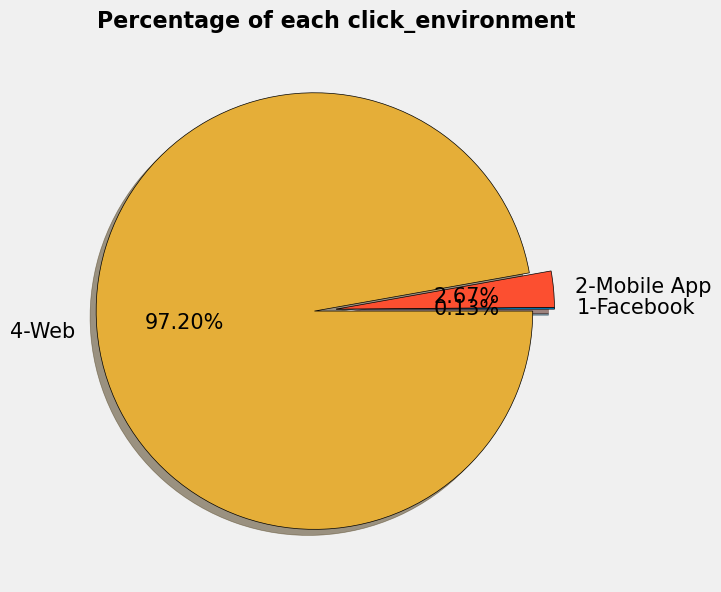

In [19]:
# Pie plot to display the percentage of each click_environment.
plt.figure(figsize=(7, 7))
labels=["1-Facebook", "2-Mobile App", "4-Web"]
slices = df_clicks.groupby("click_environment").size()
plt.pie(slices, 
        labels=labels, explode=[0, 0, 0.1], 
        shadow=True, startangle=0, autopct='%1.2f%%', 
        wedgeprops={'edgecolor': 'black'}, textprops={"fontsize":15})
plt.title("Percentage of each click_environment", 
          fontsize=16, 
          fontweight='bold')
plt.tight_layout()
plt.show()

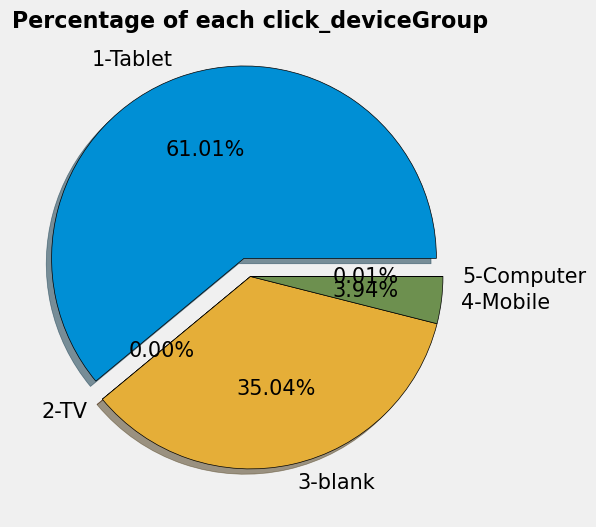

In [20]:
# Pie plot to display the percentage of each click_deviceGroup.
plt.figure(figsize=(6, 6))
labels=["1-Tablet", "2-TV", "3-blank", "4-Mobile", "5-Computer"]
slices = df_clicks.groupby("click_deviceGroup").size()
plt.pie(slices, 
        labels=labels, explode=[0.1, 0, 0, 0, 0], 
        shadow=True, startangle=0, autopct='%1.2f%%', 
        wedgeprops={'edgecolor': 'black'}, textprops={"fontsize":15})
plt.title("Percentage of each click_deviceGroup", 
          fontsize=16, 
          fontweight='bold')
plt.tight_layout()
plt.show()

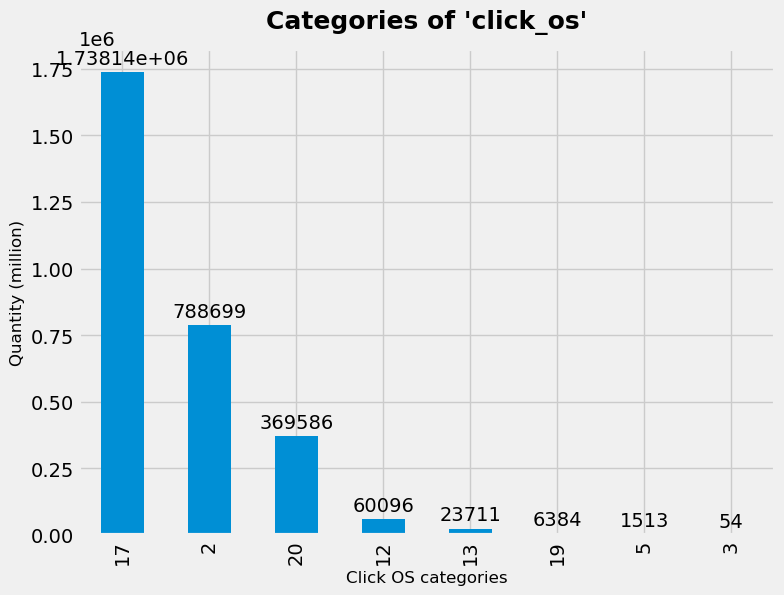

In [21]:
# Bar plot showing the different click_os categories and the respecting quantity.
ax = df_clicks['click_os'].value_counts().sort_values(ascending=False).plot.bar(
    figsize=(8, 6), fontsize=14)
plt.title("Categories of 'click_os'", 
          fontsize=18, pad=15, fontweight='bold')
plt.xlabel("Click OS categories", fontsize=12)
plt.ylabel("Quantity (million)", fontsize=12)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

### Note:  17 is ***'Firefox OS'***, 2 is ***'iOS'*** and 20 is ***'Chromecast'***

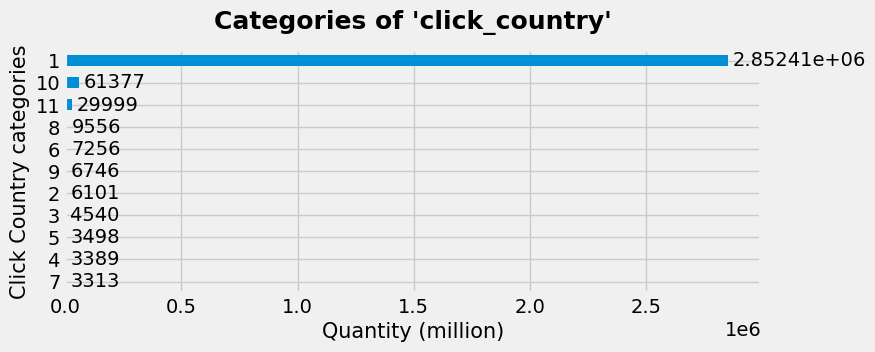

In [22]:
# Horizontal bar plot showing the different click_country and the respecting quantity.
ax = df_clicks['click_country'].value_counts().sort_values().plot.barh(
    figsize=(8, 3), fontsize=14)
plt.title("Categories of 'click_country'", 
          fontsize=18, pad=15, fontweight='bold')
plt.xlabel("Quantity (million)", fontsize=15)
plt.ylabel("Click Country categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

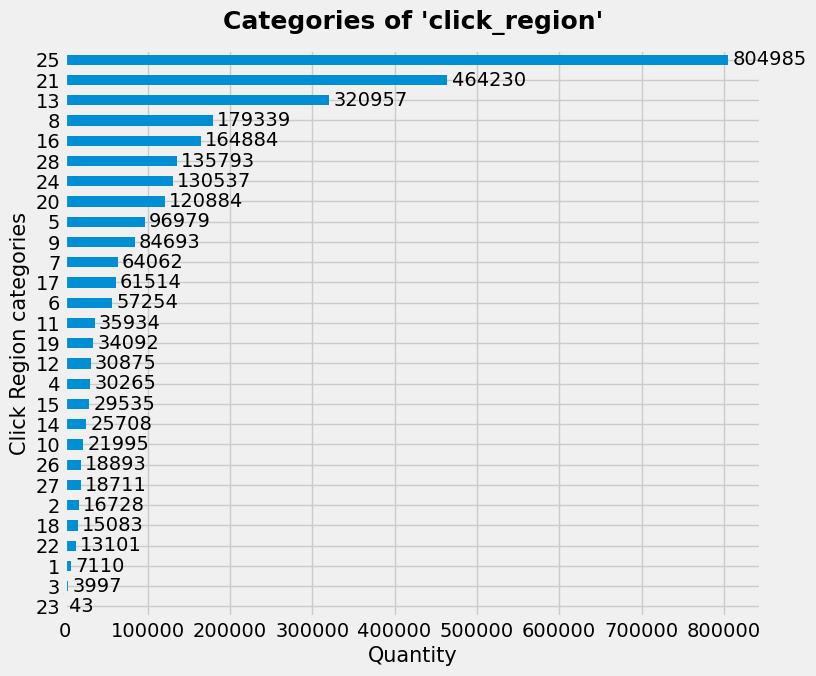

In [23]:
# Horizontal bar plot showing the different click_region and the respecting quantity.
ax = df_clicks['click_region'].value_counts().sort_values().plot.barh(
    figsize=(8, 7), fontsize=14)
plt.title("Categories of 'click_region'", 
          fontsize=18, pad=15, fontweight='bold')
plt.xlabel("Quantity", fontsize=15)
plt.ylabel("Click Region categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

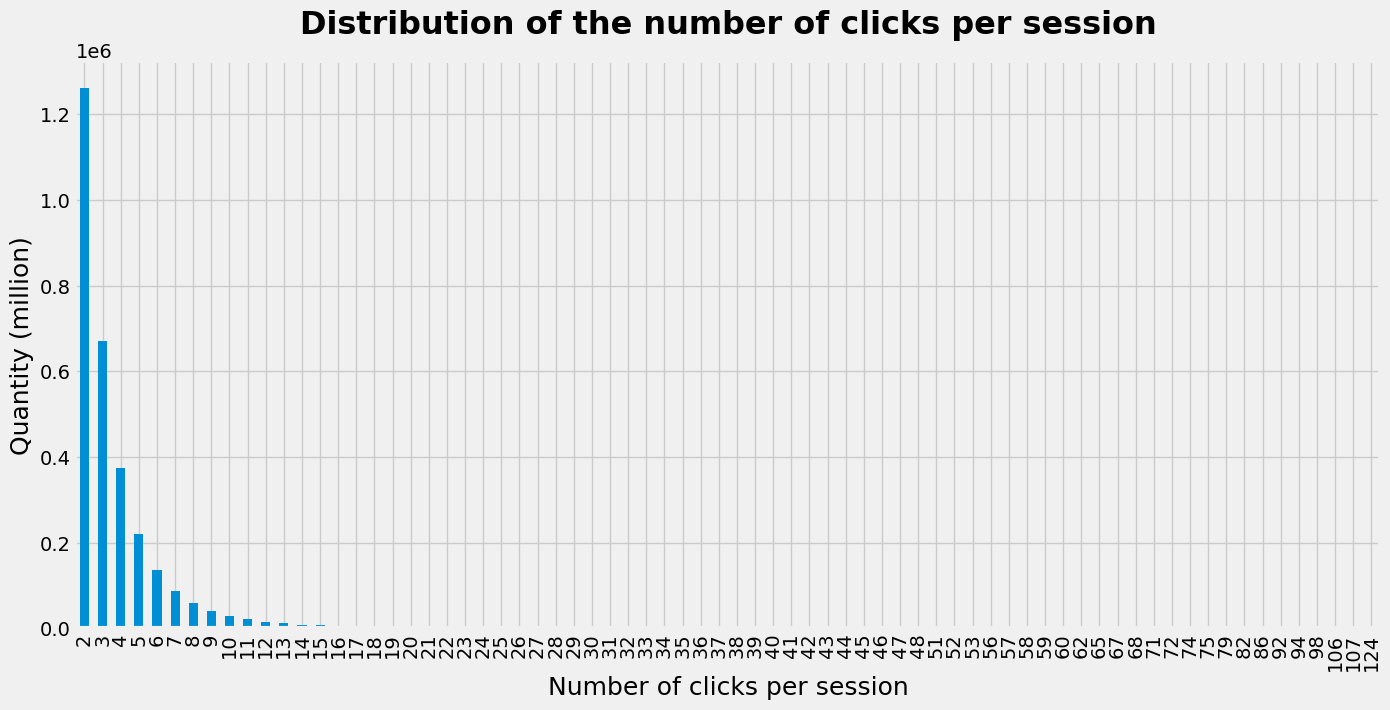

In [24]:
# Bar plot showing the distribution of the number of clicks per session.
df_clicks.groupby('session_size').size().plot(
    kind='bar', figsize=(15, 7))
plt.title("Distribution of the number of clicks per session", 
          fontsize=23, pad=20, fontweight='bold')
plt.xlabel("Number of clicks per session", fontsize=18)
plt.ylabel("Quantity (million)", fontsize=18)
ax.bar_label(ax.containers[0], padding=3, fontsize=16)
plt.show()

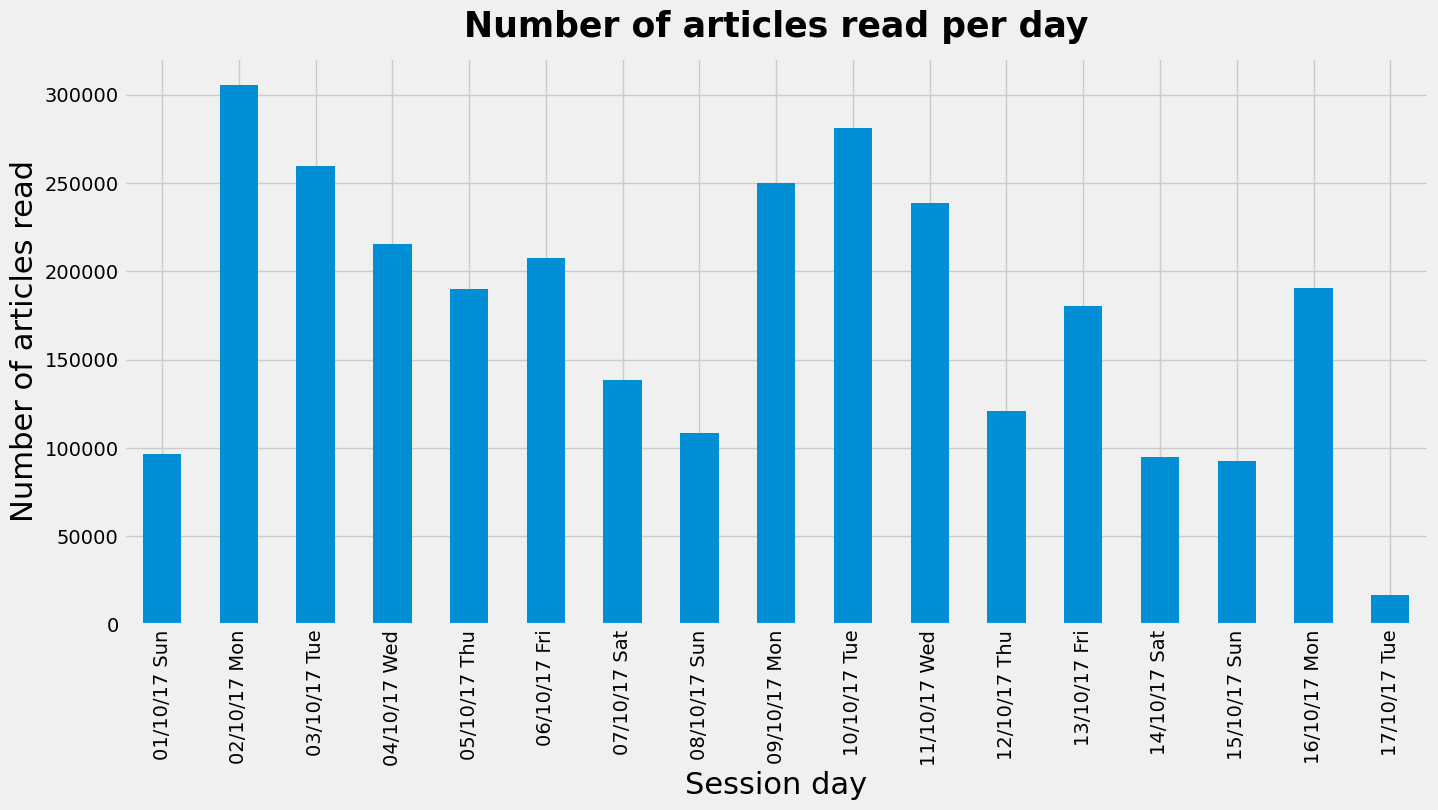

In [25]:
# Bar plot showing the Number of articles read per day.
df_clicks.groupby(df_clicks['session_start'].dt.strftime(
    '%d/%m/%y %a')).size().plot(kind='bar', figsize=(15, 7))
plt.title("Number of articles read per day", 
          fontsize=25, pad=15, fontweight='bold')
plt.xlabel("Session day", fontsize=22)
plt.ylabel("Number of articles read", fontsize=22)
plt.show()


Number of unique sessions per user: 
Mean: 16 | Median: 14 | Min: 4 | Max: 214



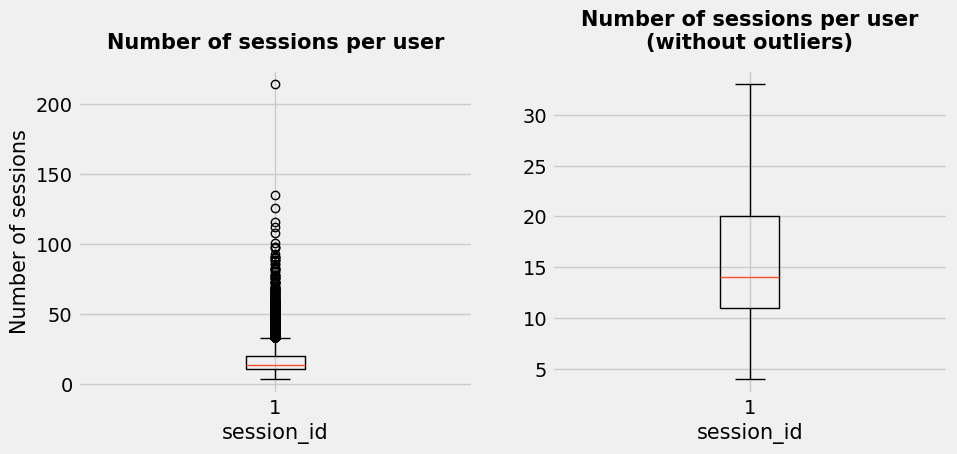

In [26]:
# Number of unique sessions per user.
x = df_clicks.groupby(['user_id'])['session_id'].nunique()
print(f'\n\033[1mNumber of unique sessions per user: \nMean: \
{round(x.mean())} | Median: {round(x.median())} | Min: {x.min()} \
| Max: {x.max()}\033[0m\n')

# Visualization of the number of sessions per user.
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))

# Plotting boxplot of the number of sessions per user.
ax1.boxplot(x)
ax1.set_title('Number of sessions per user', 
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('session_id', fontsize=15)
ax1.set_ylabel('Number of sessions', fontsize=15)

# Plotting boxplot of the number of sessions per user, without outliers.
ax2.boxplot(x, showfliers=False)
ax2.set_title('Number of sessions per user\n(without outliers)', 
              fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('session_id', fontsize=15)

plt.show()


Number of read articles per user: 
Mean: 46 | Median: 38 | Min: 8 | Max: 1254



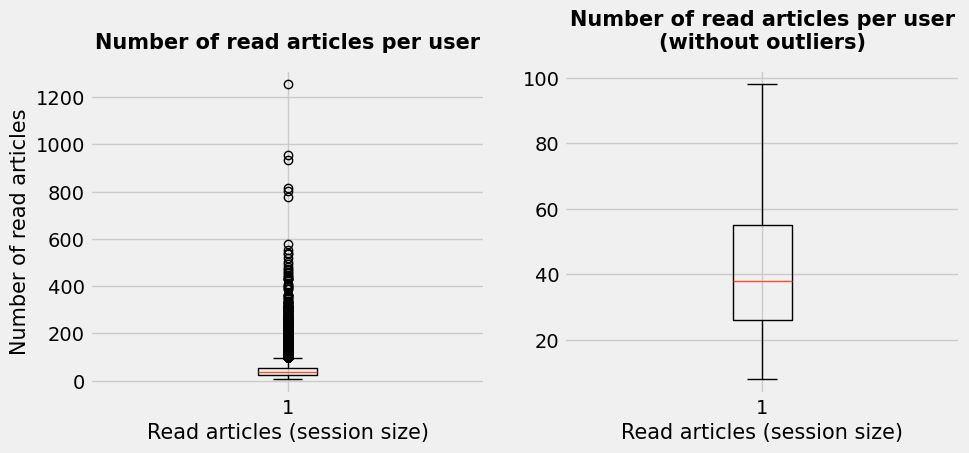

In [27]:
# Number of read articles per user during the period.
x = df_clicks.groupby(['user_id'])['session_size'].size()
print(f'\n\033[1mNumber of read articles per user: \nMean: \
{round(x.mean())} | Median: {round(x.median())} | Min: {x.min()} \
| Max: {x.max()}\033[0m\n')

# Visualization of the number of read articles per user.
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))

# Plotting boxplot of the number of read articles per user.
ax1.boxplot(x)
ax1.set_title('Number of read articles per user', 
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('Read articles (session size)', fontsize=15)
ax1.set_ylabel('Number of read articles', fontsize=15)

# Plotting boxplot of the number of read articles per user, without outliers.
ax2.boxplot(x, showfliers=False)
ax2.set_title('Number of read articles per user\n(without outliers)', 
              fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('Read articles (session size)', fontsize=15)

plt.show()

### The essential part of the interaction between the users and the news articles is via the globo.com web page, in majority using a tablet devise, mostly with Firefox OS, then iOS.

### Almost all users are from Brazil, from one of its 26 states or the federal district (regions here).

### During a typical session, the user would read 2 or 3 different articles, mostly at the beginning of the week.

### Finally, each user, during the period, had between 4 to 214 sessions, with a median of 14.<br>They each read between 8 to 1254 news articles, with a median of 38.

## • df_articles

### Let's dive now into the articles.

In [28]:
# First, let's see if we have articles without words_count.
no_words_count = df_articles[df_articles['words_count'] == 0].nunique()[0]
print(f"\033[1mNumber of articles with 'words_count'=0: \
{no_words_count}\033[0m")

Number of articles with 'words_count'=0: 35


We decide to do nothing about it.

In [29]:
# Minimum and maximum number of words in the news articles.
min_words = df_articles['words_count'].min()
max_words = df_articles['words_count'].max()
print(f"\033[1m\nThe articles contain between {min_words} \
and {max_words} words.\033[0m")


The articles contain between 0 and 6690 words.


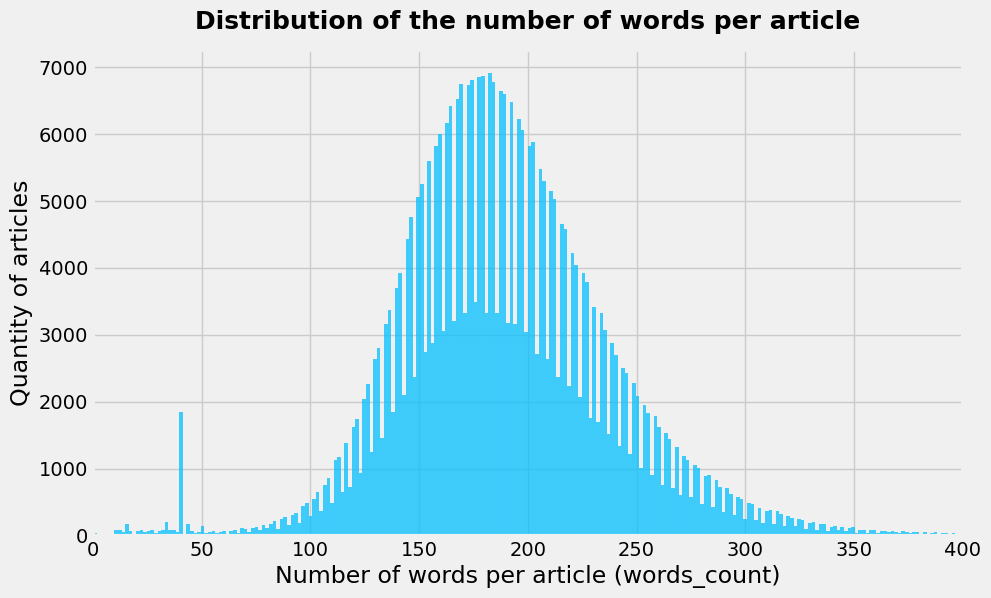

In [30]:
# Distribution of the number of words per article.
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_articles['words_count'], color="deepskyblue")

plt.xlim([0, 400])  # limiting to a maximum 400 words per article.
plt.title("Distribution of the number of words per article", 
          fontsize=18, fontweight='bold', pad=15)
plt.xlabel("Number of words per article (words_count)", fontsize=17)
plt.ylabel("Quantity of articles", fontsize=17)
plt.show()

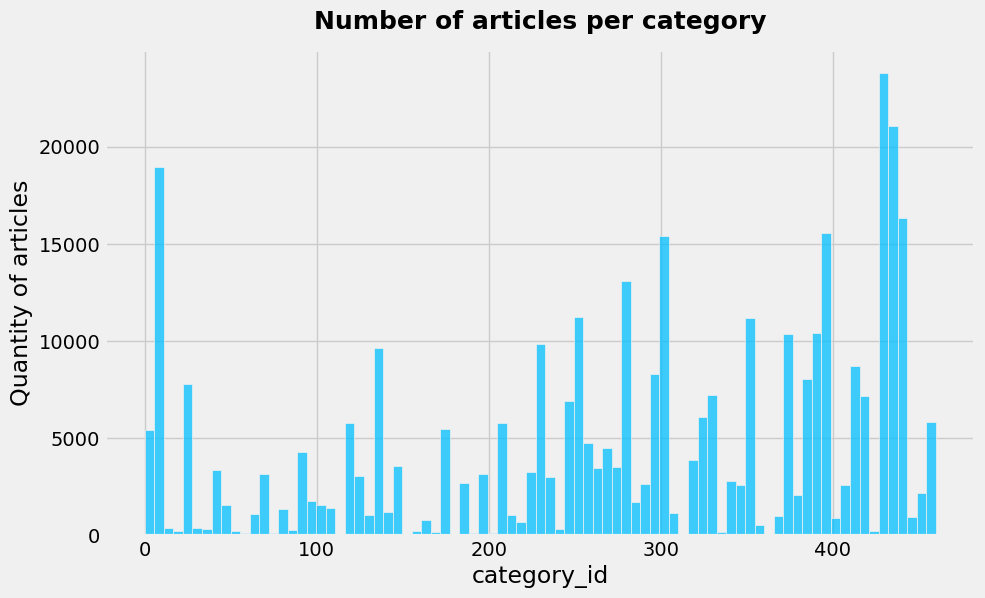

In [31]:
# Distribution of the number of words per article.
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_articles['category_id'], color="deepskyblue")

plt.title("Number of articles per category", 
          fontsize=18, fontweight='bold', pad=15)
plt.xlabel("category_id", fontsize=17)
plt.ylabel("Quantity of articles", fontsize=17)
plt.show()

## • Merging the 2 dataframes

### Let's merge df_clicks and df_articles on the base of the article_id.

In [32]:
# Renaming one column.
df_clicks.rename(columns={'click_article_id':'article_id'}, inplace=True)

# Joining df_clicks and df_articles on the 'article_id' column. 
df_merged = df_clicks.merge(df_articles, on='article_id', how='left')

# Displaying the shape and a sample of 5 rows.
print(f"\n\033[1mdf_merged shape:\033[0m {df_merged.shape}\n")
df_merged.sample(5)


df_merged shape: (2988181, 16)



,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,...,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count
2255790,56806,1507752699191013,2017-10-11 20:11:39,4,288435,2017-10-11 20:12:01.535,4,...,1,16,2,418,2017-10-11 07:51:10,0,241
1985197,25051,1507659405552317,2017-10-10 18:16:45,2,29953,2017-10-10 18:17:52.346,4,...,1,25,2,26,2017-10-10 11:09:24,0,175
2222900,18088,1507745419249768,2017-10-11 18:10:19,3,119534,2017-10-11 18:12:09.821,4,...,1,13,2,247,2017-10-11 12:06:31,0,188
2498742,3201,1507903936207967,2017-10-13 14:12:16,4,284583,2017-10-13 17:25:22.238,4,...,1,9,2,412,2017-10-13 08:25:54,0,200
1067183,17292,1507247871413968,2017-10-05 23:57:51,2,207797,2017-10-06 01:07:05.167,4,...,1,25,1,331,2017-10-05 20:42:59,0,258


<function matplotlib.pyplot.show(close=None, block=None)>

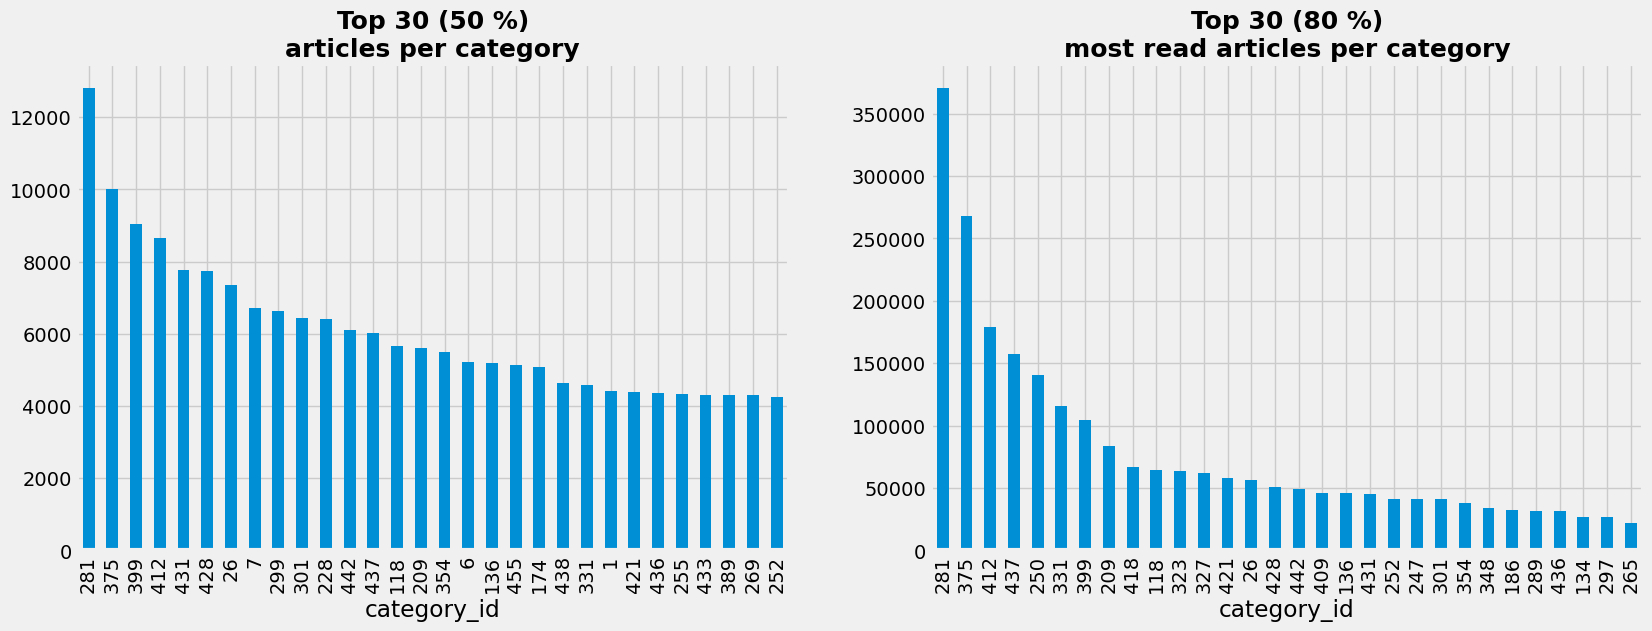

In [33]:
# Grouping articles by category.
art_cat = df_articles.groupby(
    'category_id')['article_id'].nunique().sort_values(ascending=False)
read_art_cat = df_merged.groupby(
    'category_id')['article_id'].count().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting the number of articles per category.
art_cat.head(30).plot(kind='bar', ax=ax1)
perc1 = round(sum(art_cat.head(30))/sum(art_cat) * 100)
ax1.set_title(
    f'Top 30 ({perc1} %)\narticles per category', 
    fontsize=18, fontweight='bold')

# Plotting the number of articles per category.
read_art_cat.head(30).plot(kind='bar', ax=ax2)
perc2 = round(sum(read_art_cat.head(30))/sum(read_art_cat) * 100)
ax2.set_title(
    f'Top 30 ({perc2} %)\nmost read articles per category',
    fontsize=18, fontweight='bold')

plt.show

### Finally, fdfgfg articles have been read during the period of time, from 461 different categories.

<h2><div class="alert alert-block alert-success" id="section_1">
PART 1 - DATA PREPARATION</div></h2>

<h3><div class="alert alert-block alert-info" id="section_1A">
A - FINAL DATASET FOR MODELLING</div></h3>

In [34]:
# Cleaning the final dataset of useless columns.
df_merged.drop(columns=[
    'session_start', 'session_size', 'click_timestamp', 
    'click_environment', 'click_deviceGroup', 'click_os', 
    'click_country', 'click_region', 'click_referrer_type', 
    'created_at_ts', 'publisher_id'], inplace=True)
df_merged

,user_id,session_id,article_id,category_id,words_count
0,0,1506825423271737,157541,281,280
1,0,1506825423271737,68866,136,226
2,1,1506825426267738,235840,375,159
3,1,1506825426267738,96663,209,206
4,2,1506825435299739,119592,247,239
...,...,...,...,...,...
2988176,10051,1508211372158328,84911,174,171
2988177,60752,1508211376302329,30760,26,162
2988178,60752,1508211376302329,157507,281,370
2988179,58182,1508211379189330,234481,375,212


### Rating per user = Total clicks per category / Total clicks ???

<h3><div class="alert alert-block alert-info" id="section_1B">
B - EMBEDDING</div></h3>

In [35]:
ffffffff

NameError: name 'ffffffff' is not defined

In [ ]:
# Calculate view recency
df_merged['view_recency'] = df_merged['click_timestamp'] - df_merged['created_at_ts']
df_merged['view_recency'] = (df_merged['view_recency'] / pd.Timedelta(days=1))

# Filter article by popularity
articles_popularity = df_merged.groupby('article_id', as_index=False)['click_timestamp'].count()
articles_popularity.rename(columns={'click_timestamp':'nbClicks'}, inplace=True)
articles_popularity.sort_values(by=['nbClicks'], ascending=False, inplace=True)

# Keep only the top 10 articles for analysis
articles_top10 = articles_popularity.head(10)

# Merge the top10 with 1st DF to track creation and start session date
articles_top10 = pd.merge(articles_top10, clicks_articles, on='article_id')

# Ensure there is no inconsistent data
articles_top10 = articles_top10[articles_top10.view_recency >= 0]
print('Top10 articles interactions shape: ', articles_top10.shape)

# Create DF with only the top10 articles
top10_clicks_per_day = pd.DataFrame(
    articles_top10.groupby(['article_id','view_recency'], as_index=False)['click_timestamp'].count())

# Display shape and 5 first rows
print('Top10 articles views shape: ', top10_clicks_per_day.shape)
top10_clicks_per_day.head()

In [ ]:
# Plot articles view per 1st day to 15th day
plt.figure(figsize=(15, 4))
palette = sns.color_palette('hls', 10)
sns.lineplot(x=top10_clicks_per_day['view_recency'],
             y=top10_clicks_per_day['click_timestamp'],
             hue=top10_clicks_per_day['article_id'],
             data=top10_clicks_per_day,
             palette=palette,
             marker='o')
plt.xticks(range(0, len(top10_clicks_per_day.view_recency.unique())+1))
plt.xlabel('Recency of reading day')
plt.legend(top10_clicks_per_day.article_id.unique(), title='articleID')
plt.title('# of readings per day in top 10 articles',
          fontsize=14, fontweight='bold')
plt.show()


In [ ]:
#########################

In [ ]:
with open(r"datasets/articles_embeddings.pickle", "rb") as input_file:
    e = cPickle.load(input_file)

In [ ]:
def getFiveArticles(e, userId):
    
    ee=e
    #get all articles read by user
    var= frame.loc[frame['user_id']==userId]['click_article_id'].tolist()
    #chose randomly one
    value = randint(0, len(var))
    #delete all read articles except the selected one( we do not want to offer user to read something he already read)
    for i in range(0, len(var)):
        if i != value:
            ee=np.delete(ee,[i],0)
    arr=[]
    
    #delecte selected article in the new matrix
    f=np.delete(ee,[value],0)
    #get 5 articles the most similar to the selected one
    for i in range(0,5):
        distances = distance.cdist([ee[value]], f, "cosine")[0]
        min_index = np.argmin(distances)
        f=np.delete(f,[min_index],0)
        #find corresponding matrix in original martix
        result = np.where(e == f[min_index])
        arr.append(result[0][0])
        
    return arr

Content based filtering based on articles embeddings

selecting 5 closest articles using cosin distance¶

In [ ]:
print(getFiveArticles(e, 92059))

Adding words count to article embeddings and selecting 5 closes articles

In [ ]:
d=e
max=articles['words_count'].max()
articles['words_count']= articles['words_count'].apply(lambda x: x/max)

d=np.append(d,np.reshape(articles['words_count'].to_numpy(), newshape=(articles['words_count'].shape[0],1)),axis=1)

d.shape

In [ ]:
print(getFiveArticles(d, 92059))

<h3><div class="alert alert-block alert-info" id="section_1C">
C - PERFORMANCE METRICS</div></h3>

<h2><div class="alert alert-block alert-success" id="section_2">
PART 2 - CONTENT-BASED APPROACH</div></h2>

UTILISATION DE L'EMBEDDING

**Élaboration d’un modèle content based filtering**<br>
• Pendre le dernier article cliqué par l’utilisateur.<br>
• Prendre au hasard un article parmi ceux cliqués.<br>
• Faire une moyenne des embeddings des articles ou des derniers articles, pondérés ou non par le nombre de clics sur chaque article.<br>
• Le fichier « articles_embeddings » permet de s’affranchir d’un prétraitement « Tf-idf ».<br> 
• La démarche consiste à réaliser un calcul de similarité cosine des « embeddings » entre un article de l’utilisateur et l’ensemble des autres articles, et de prendre les 5 articles les plus proches. Dans la plupart des cas l’utilisateur a cliqué sur plusieurs articles, il y a donc plusieurs stratégies possibles pour choisir l’article ; par exemple :<br>
• Pour le MVP, le calcul de similarité pourra se faire à la demande, pour l’utilisateur concerné.

Surprise is an easy-to-use Python scikit for recommender systems.

Hyperparameter tuning with cross-validation with surprise.

<h3><div class="alert alert-block alert-info" id="section_2A">
A - PRESENTATION</div></h3>

Content-based systems exploit user and item atributes/features to recommend items that match user profiles. These do not depend on user feedback or ratings.

These do not take users' behavioral information into account and discount the fact that user interest and preferences may change ober time.

############################

Content-based : using articles embedding

Method 1 : We calculate every combinaison each time (use CPU).

In [ ]:
pickle = pd.read_pickle('datasets/articles_embeddings.pickle')
pickle.shape

In [ ]:
from operator import itemgetter

def find_top_n_indices(data, top=5):
    indexed = enumerate(data)
    sorted_data = sorted(indexed, 
                         key=itemgetter(1), 
                         reverse=True) 
    return [d[0] for d in sorted_data[:top]] 

In [ ]:
def recommendFromArticle(article_id, top):
    score = []
    for i in range(0, len(pickle)):
        if(article_id != i):
            cos_sim = np.dot(pickle[article_id], pickle[i])/(np.linalg.norm(pickle[article_id])*np.linalg.norm(pickle[i]))
            score.append(cos_sim)
    
    _best_scores = find_top_n_indices(score, top)
            
    return _best_scores

In [ ]:
%%time
recommendFromArticle(157077, 10)

Method 2 : Creating a linear kernel (use Memory)

We must sample the pickle because we 'only' have 16go of RAM.

In [ ]:
cosine_similarities = linear_kernel(pickle[:50000], pickle[:50000]) 
cosine_similarities.shape

In [ ]:
titles = df_articles['article_id']
indices = pd.Series(df_articles.index, index=df_articles['article_id'])

In [ ]:
def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df.loc[userId]['categories']
    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()
    
    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)
         
    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max())
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)
    
    return _matrix

In [ ]:
def simScores(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    
    return sim_scores
    print(sim_scores)

In [ ]:
def predictWSimScores(userId):
    _input_user_ratings = inputUserRatings(userId)
    _result = []
    for index, row in _input_user_ratings.iterrows():
        _x = simScores(row.category_id)
        for i in range(1, row.click + 1):
            _result = _result + _x
    return _result

In [ ]:
%%time
test = predictWSimScores(0)

In [ ]:
pd.DataFrame(test, columns =['category_id', 'score']).groupby(
    'category_id').mean().sort_values('score',ascending=False).head(5)

<h2><div class="alert alert-block alert-success" id="section_3">
PART 3 - COLLABORATIVE FILTERING APPROACH</div></h2>

**Élaboration d’un modèle de type Collaborative Filtering**<br>
Il n’y a pas de Rating explicite (comme par exemple une note d’appréciation des articles par les utilisateurs) ; il est donc nécessaire de déterminer un Rating implicite, par exemple le nombre de clics pour un utilisateur sur un article. Ce nombre peut être pondéré, selon l’activité de l’utilisateur, par exemple par son nombre total de clics ou le nombre de clics sur sa session (session_size).

<h3><div class="alert alert-block alert-info" id="section_3A">
A - PRESENTATION</div></h3>

Collaborative filtering based systems collect & analyze users’ behavioral information in the form of their feedback, ratings, preferences and activities. Based on this information, these then exploit similarities amongst several users/ items to predict missing ratings and hence make suitable recommendations. Collaborative filtering systems can discover and learn features on its own without the need of explicit features to profile items or users.

#### • Memory-based/Neighborhood-based

- User-based: The key notion here is to determine users, who are like the target user A, and recommend ratings for the unobserved ratings of A by calculating weighted averages of the ratings of this peer group. User-based approach finds n users who have rated the movies similar to user A. Similarity measure like Cosine similarity, Pearson similarity are used, and a weighted average of ratings of k most similar users is taken. En gros, on cherche des users qui ont les mêmes goûts e films que le user et on note le film comme eux l'ont noté. 

- Item-based: Item-based approach finds n movies which have been rated similar to The Hobbit by other users. To predict the rating that user A will give to The Hobbit, a weighted average of ratings of k most similar movies is taken. En gros le rating donné par les autres users sur n autres films a été le meme que celui cherché, donc il faut noter le film de la meme façon que le user a noté ces autres films.

#### • Model-based/Matrix Factorization

Model-based Collaborative Filtering approach employs dimensionality reduction techniques like matrix factorization (Singular Value Decomposition — SVD, Principal Component Analysis- PCA and Latent Factor models) to discover hidden concepts and their relationship with users and items.<br>
Matrix factorization allows User-Item rating matrix to be decomposed into smaller user-concept matrix and item-concept matrix, where each user and item is represented by f-dimensional vectors. Elements of user vector measure the extent of interest user has in each of the f concepts (features/factors). Elements of item vector measure the extent of strength of each of the concepts against that item. The dot product of user and item vectors i∙u = i’u is used to estimate user’s interest in a specific item.<br>
Referring to the movie recommendation example above, user-movie rating matrix can be represented by lower dimensional user-concept and movie-concept matrix where romance and action could be the latent concepts (not known in advance) or features defining the user-movie interactions. Choice of f is a trade-off between discovering hidden concepts and avoiding overfitting, therefore, f should be chosen wisely.<br><br>
For large number of users and items, collaborative filtering approaches however suffer from sparsity problems (as many of the items are not rated by users) and hence accuracy of the system falls-off. However, model-based CF systems are more scalable as compared to memory-based systems and are more robust to deal with sparsity issues.<br>
Unlike CB recommender systems, CF recommender systems are more versatile and do not require feature modeling specific to domain.

##########################

On va faire les 2 approches avec la seule approche user-based filtering, pas item-based filtering car.......

Approche 1 de Centered k-NN avec KNNWithMeans de surprise

Approche 2 de Matrix Factorization avec SVD de surprise

In [1]:
#####################  REAL PYTHON

In [ ]:
reader = Reader(rating_scale=(1, 5))  # why 1, 5 ???

# class surprise.reader.Reader(name=None, line_format='user item rating', sep=None, rating_scale=(1, 5), skip_lines=0)[source]
# The Reader class is used to parse a file containing ratings.
# Such a file is assumed to specify only one rating per line, and each line needs to respect the following structure:
# user ; item ; rating ; [timestamp]
# where the order of the fields and the separator (here ‘;’) may be arbitrarily defined (see below). brackets indicate that the timestamp field is optional.
# For each built-in dataset, Surprise also provides predefined readers which are useful if you want to use a custom dataset that has the same format as a built-in one (see the name parameter).
# Parameters
# name (string, optional) – If specified, a Reader for one of the built-in datasets is returned and any other parameter is ignored. Accepted values are ‘ml-100k’, ‘ml-1m’, and ‘jester’. Default is None.
# line_format (string) – The fields names, in the order at which they are encountered on a line. Please note that line_format is always space-separated (use the sep parameter). Default is 'user item rating'.
# sep (char) – the separator between fields. Example : ';'.
# rating_scale (tuple, optional) – The rating scale used for every rating. Default is (1, 5).
# skip_lines (int, optional) – Number of lines to skip at the beginning of the file. Default is 0.


# Loads Pandas dataframe.
data = Dataset.load_from_df(df[["user_id", "article_id", "rating"]], reader)

In [ ]:
# To use item-based cosine similarity
# KNNWithMeans: A basic collaborative filtering algorithm, taking into account the mean ratings of each user.
sim_options = {
    "name": "cosine", 
    "user_based": False,  # Compute  similarities between items 
}
algo = KNNWithMeans(sim_options=sim_options)

In [ ]:
algo.fit(trainset)

In [ ]:
prediction = algo.predict('E', 2)
prediction.est

The GridSearchCV class computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. This is useful for finding the best set of parameters for a prediction algorithm. It is analogous to GridSearchCV from scikit-learn.

In [ ]:
sim_options = {
    "name": ["msd", "cosine"], 
    "user_based": [False, True],
    "min_support": [3, 4, 5],  # why ? the minimum number of common items needed between users to consider them for similarity
}
# msd: Compute the Mean Squared Difference similarity between all pairs of users (or items)
# cosine: Compute the cosine similarity between all pairs of users (or items).

param_grid = {
#     "k": [30, 40, 50],
#     "min_k": [1, 2, 3], 
    "sim_options": sim_options
}

gs = GridSearchCV(KNNWithMeans, 
                  param_grid, 
                  measures=["rmse", "mae"],
                  n_jobs=-1,  # all CPUs are used.
                  cv=5)
gs.fit(data)

print(gs.best_score["rmse"])  # Root Mean Squared Error
print(gs.best_params["rmse"])
print(gs.best_score["mse"])  # Mean Squared Error
print(gs.best_params["mse"])
print(gs.best_score["mae"])  # Mean Absolute Error
print(gs.best_params["mae"])

In [ ]:
# The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. 
param_grid = {
    "n_epochs": [5, 10],  # The number of iteration of the SGD procedure. Default is 20.
    "lr_all": [0.002, 0.005],  # The learning rate for all parameters. Default is 0.005.
    "reg_all": [0.4, 0.6],  # The regularization term for all parameters. Default is 0.02.
}
gs = GridSearchCV(SVD(random_state=52), 
                  param_grid, 
                  measures=["rmse", "mae"], 
                  cv=5)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])
print(gs.best_score["mse"])
print(gs.best_params["mse"])
print(gs.best_score["mae"])
print(gs.best_params["mae"])

In [ ]:
#####################################

In [ ]:
clicks_articles2 = clicks_articles[['user_id', 'article_id', 'category_id']]
clicks_articles2

In [ ]:
%%time
series = clicks_articles2.groupby(['user_id', 'category_id']).size()
user_rating_matrix = series.to_frame()
user_rating_matrix = user_rating_matrix.reset_index()
user_rating_matrix.rename(columns={0: 'rate'}, inplace=True)

In [ ]:
user_rating_matrix

1882302 rows × 3 columns

In [ ]:
# As we're loading a custom dataset, we need to define a reader.
reader = Reader()  # rating_scale=(1, 10)

In [ ]:
_x = user_rating_matrix.loc[user_rating_matrix.rate > 1]
data = Dataset.load_from_df(
    _x[['user_id', 'category_id', 'rate']], reader)
print(f"We have selected {len(_x)} interections.")

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(
    data, test_size=0.25, random_state=52)

In [ ]:
# We'll use the famous Singular Vector Decomposition (SVD) algorithm.
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset.
algo.fit(trainset)
predictions = algo.test(testset)

In [ ]:
# Then compute RMSE.
accuracy.rmse(predictions)

We have selects 503616 interactions.

7.413344626148932

In [ ]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
%%time
top_n = get_top_n(predictions, n=10)

In [ ]:
with open("top_n.txt", "wb") as fp:
    pickle.dump(top_n, fp)

In [ ]:
def findRecom(dic, userId):
    res = []
    query = dic[userId]
    for uid, user_ratings in query:
        res.append(uid)
    return res

In [ ]:
findRecom(top_n, 0)

[186, 281]

<h2><div class="alert alert-block alert-success" id="section_00">
CONCLUSION</div></h2>

### • Hybrid Approach

Memory-based and model-based collaborative filtering approaches can be combined in practice to exploit the benefits each of the approaches provide. Also, content-based and collaborative filtering approaches can be combined in various ways to achieve greater synergies between them.

<img src="my_content.png" width="250" height="250">

Dans la deuxième architecture, tu peux te passer de l’API, en exploitant les fonctionnalités “Azure Blob storage input binding” pour récupérer directement les fichiers et modèles, et en intégrant tes prédictions directement dans ton Azure Functions

Il est conseillé de créer votre Azure Function directement sur le portail Azure, et de choisir le “plan type” égal à “Consomption(serverless)”, afin d’utiliser l’option gratuite de Service Plan

Sélectionner l’architecture logicielle permettant de répondre au besoin métier :<br> 
    • les différentes briques d’architecture nécessaires pour la réalisation de la solution répondant au besoin métier ont été identifiées.<br>
    • la description fonctionnelle de chaque brique d’architecture a été réalisée.<br>
    • les besoins de mise à jour des bases de données Utilisateurs et Articles ont été pris en compte dans la description fonctionnelle.<br>
    • une explication sous forme de schéma des différentes briques de l’architecture logicielle a été élaborée.<br>
    

### Django Application

Pour l’application, tu peux créer en local une simple interface qui liste les id des users et affiche les résultats des 5 suggestions d’articles, suite à appel de l’Azure Functions.

 fichier “embeddings” : tu peux réaliser une réduction de dimension de ce fichier via une ACP.

une architecture serverless avec Azure Functions 